Text clustering with fasttext

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from ast import literal_eval
# from hazm import *
# from hazm import stopwords_list
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.models.keyedvectors import KeyedVectors
from functools import lru_cache
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from operator import itemgetter
import pickle
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples , silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()

In [ ]:
import csv
## Loading Data and stopwords
# path = r'\hindi-test.csv'
path = r'/content/drive/MyDrive/Hindi-Dataset-BTP/hindi-train.csv'


# with open(path) as f:
#     dialect = csv.Sniffer().sniff(f.read(1024))
#     delimiter = dialect.delimiter

data = pd.read_csv(path, sep="\t", encoding='utf-8', header=None)
# data = pd.read_csv(path, delimiter ='"')
# print(delimiter)
print(data.head())
# sw_path = '\final_stopwords'

stopwords_file_path = '/content/drive/MyDrive/Hindi-Dataset-BTP/final_stopwords.txt'

def read_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = [line.strip() for line in file]
    return stopwords_list

# Read stopwords from the file
stopwords = read_stopwords(stopwords_file_path)

# Print the stopwords list
print(stopwords)
# stopwords = ["ही", "है", "हूँ", "हैं", "यह", "ये", "वह", "वे", "मैं", "हम", "तुम", "आप", "से", "को", "में","पर", "जैसे", "इस", "उस", "इसका", "उसकी", "इन", "उनका", "उनके", "से", "में", "पर", "के", "को", "से", "जैसे", "इस", "उस", "इसका", "उसकी", "इन", "उनका", "उनके"]

# with open(sw_path) as f:
#     stopwords = pickle.load(f)

          0                                                  1
0     india  मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1  pakistan  नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2      news  इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3     india  प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ...
4     india  ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...
['मैं', 'मुझको', 'मेरा', 'अपने आप को', 'हमने', 'हमारा', 'अपना', 'हम', 'आप', 'आपका', 'तुम्हारा', 'अपने आप', 'स्वयं', 'वह', 'इसे', 'उसके', 'खुद को', 'कि वह', 'उसकी', 'उसका', 'खुद ही', 'यह', 'इसके', 'उन्होने', 'अपने', 'क्या', 'जो', 'किसे', 'किसको', 'कि', 'ये', 'हूँ', 'होता है', 'रहे', 'थी', 'थे', 'होना', 'गया', 'किया जा रहा है', 'किया है', 'है', 'पडा', 'होने', 'करना', 'करता है', 'किया', 'रही', 'एक', 'लेकिन', 'अगर', 'या', 'क्यूंकि', 'जैसा', 'जब तक', 'जबकि', 'की', 'पर', 'द्वारा', 'के लिए', 'साथ', 'के बारे में', 'खिलाफ', 'बीच', 'में', 'के माध्यम से', 'दौरान', 'से पहले', 'के बाद', 'ऊपर', 'नीचे', 'को', 'से', 'तक', 'से नीचे

In [ ]:
import nltk
import re
nltk.download('wordnet')
# nltk.download('')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from functools import lru_cache
from tqdm import tqdm

# Download the punkt tokenizer if not already downloaded
nltk.download('punkt')

# Assuming stopwords is defined somewhere in your code

# Create a lemmatizer object
lemmatizer = nltk.stem.WordNetLemmatizer()

# Apply lru_cache to the lemmatizer function
lemmatize = lru_cache(maxsize=500000)(lemmatizer.lemmatize)

def clean(text, stopwords):

    text = re.sub(r'\s+', ' ', text).strip()
    # Remove Hindi numbers
    text = re.sub(r'[०-९]+', '', text)
    hindi_sentence = re.compile('(बीबीसी हिन्दी के एंड्रॉएड ऐप के लिए यहां क्लिक करें. आप हमें फ़ेसबुक और ट्विटर पर भी फ़ॉलो कर सकते हैं.)')
    # text = re.sub(re.escape(hindi_sentence), '', text)
    text = re.sub(hindi_sentence, '', text)

    text = re.sub(r'\d+(\.\d+)?', '', text)
    # Remove unnecessary commas, dots, and s
    cleaned_text = re.sub(r'[`.,?\s]+', ' ', text)

    # Remove alphanumeric items
    text = re.sub(r'\b[0-9a-zA-Z]+\b', '', text)

    # Remove the specified line
    cleaned_text = re.sub(r'\(बीबीसी हिन्दी के.*\)','', cleaned_text).strip()

    # Tokenize and remove stopwords
    tokens = [lemmatize(i) for i in word_tokenize(cleaned_text) if i not in stopwords]

    return tokens

data.columns = ['title', 'desc']



data.drop_duplicates(subset='desc', inplace=True)
data.dropna(inplace=True)

data['Final'] = data['title'].str.cat(data['desc'], sep='|')

print(data['Final'].head())
data['clean'] = data['Final'].progress_apply(lambda x: clean(x, stopwords))

print(data['clean'].iloc[2])



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    india|मेट्रो की इस लाइन के चलने से दक्षिणी दिल...
1    pakistan|नेटिजन यानि इंटरनेट पर सक्रिय नागरिक ...
2    news|इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार...
3    india|प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड...
4    india|ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे ...
Name: Final, dtype: object


100%|██████████| 3458/3458 [00:19<00:00, 175.40it/s]

['news|इसमें', 'फ़्लाइट', 'एटेनडेंट', 'मदद', 'गुहार', 'डिक', 'चेनी', 'के', 'निर्देश', 'ज़िक्र', 'उन्होंने', 'विमानों', 'मार', 'गिराने', 'बात', 'अपहरणकर्ता', 'मोहम्मद', 'अता', 'धमकियाँ', 'सुनी', 'ऑडियो', 'आयोग', 'के', 'तैयार', 'ज़्यादातर', 'बातें', 'लिखित', 'रूप', 'प्रकाशित', 'चुकी', 'रिकॉर्डिंग', 'अमेरिकन', 'एयरलाइन्स', 'के', 'फ़्लाइट', 'नंबर', 'फ़्लाइट', 'एटेनडेंट', 'बेटी', 'फ़ोन', 'कॉल', 'बोल', 'बिज़नस', 'श्रेणी', 'स्टैब', 'पता', 'नहीं', 'लगता', 'अपहरण', 'अपहरणकर्ता', 'मोहम्मद', 'अता', 'बोलते', 'सना', 'हिलेगा', 'नहीं', 'सब', 'ठीक', 'रहेगा', 'कोशिश', 'आपको', 'नुकसान', 'विमान', 'चुपचाप', 'बैठे', 'रहें', 'ज़्यादातर', 'रिकॉर्डिंग', 'फ़ेडरल', 'एविएशन', 'एडमिनिस्ट्रेशन', 'विमान', 'वर्ल्ड', 'ट्रेड', 'सेंटर', 'टकरा', 'चुका', 'ऑडियो', 'सुना', 'कन्ट्रोलर', 'विमान', 'बात', 'मैनहेटन', 'ऑडियो', 'आवाज़', 'बोल', 'विमान', 'अभी-अभी', 'वर्ल्ड', 'ट्रेड', 'सेंटर', 'टकराया', 'कहता', 'पूरी', 'इमारत', 'बिखर', 'अफ़रा-तफ़री', 'के', 'आलम', 'फ़ाइटर', 'जेट', 'पूर्व', 'ओर', 'उड़ान', 'भरते', 'सैन्य', 'कमांडर', 'ज

In [ ]:
data = data.loc[data['title'].isin(['india','international', 'news','science','sport','entertainment'])]
print(len(data))

3255


In [ ]:
#Remove duplicated values after preprocessing

_,idx = np.unique(data['clean'],return_index = True)
data = data.iloc[idx,:]

# Remove values with less than 50 words (commercial or incomplete news)
# this may be changed as per the need
df=data.loc[data.Final.map(lambda x :len(x) > 0),['Final','clean']]


mylist = list()
for i,j in tqdm(df.iterrows()):
    sent = j['clean']
    mylist.append(sent)



3254it [00:00, 19825.35it/s]


In [ ]:
#Loading Fasttext pretrained word2vec model
# pip install fasttext
# import fasttext
!pip install fasttext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=df73561daf6f7e521e91153ab14078623799365d7b4e98d09e896b51adeb0810
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext.util
import fasttext

In [ ]:
# fasttext.util.download_model('hi', if_exists='ignore')  # For hindi

In [ ]:

#Loading Fasttext pretrained in vectorised format
model_path = r'/content/drive/MyDrive/Hindi-Dataset-BTP/cc.hi.300.vec'
model = KeyedVectors.load_word2vec_format(model_path)


In [ ]:
#Testing model by giving words
model.most_similar('भारत')

[('देश', 0.6862446069717407),
 ('भारतीय', 0.6340397596359253),
 ('पाकिस्तान', 0.6237473487854004),
 ('राज्य', 0.6183289289474487),
 ('विश्व', 0.5960472822189331),
 ('चीन', 0.5896427035331726),
 ('प्रदेश', 0.5875652432441711),
 ('अमेरिका', 0.5864876508712769),
 ('ब्रिटिश', 0.5656977295875549),
 ('दक्षिण', 0.5627919435501099)]

In [ ]:

#Generating Vectors for list of documents (list of cleaned tokens)
def vectorize(list_of_docs, model):

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features



In [ ]:

# for k = 2
#Generating clusters and sillhouete score by kmeans alg (MiniBatchKMeans could be used too)
def kmeans_clusters(
	X,
    k,
    print_silhouette_values,
):

    km = KMeans(init='k-means++',max_iter =10000,n_clusters=k).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print("Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

vectorized_docs = vectorize(mylist, model=model)
#choosing right number of clusters w.r.t scores

clustering, cluster_labels = kmeans_clusters(
	X=vectorized_docs,
    k=2,
    print_silhouette_values=True,
)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2
Silhouette coefficient: 0.35
Inertia:93.27217286274487
Silhouette values:
    Cluster 1: Size:3138 | Avg:0.36 | Min:0.05 | Max: 0.46
    Cluster 0: Size:116 | Avg:0.21 | Min:-0.06 | Max: 0.41


In [ ]:

#FOR k = 6


#Generating clusters and sillhouete score by kmeans alg (MiniBatchKMeans could be used too)
def kmeans_clusters(
	X,
    k,
    print_silhouette_values,
):

    km = KMeans(init='k-means++',max_iter =10000,n_clusters=k).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print("Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

vectorized_docs = vectorize(mylist, model=model)
#choosing right number of clusters w.r.t scores

clustering, cluster_labels = kmeans_clusters(
	X=vectorized_docs,
    k=6,
    print_silhouette_values=True,
)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6
Silhouette coefficient: 0.06
Inertia:78.41760766033242
Silhouette values:
    Cluster 5: Size:56 | Avg:0.37 | Min:0.01 | Max: 0.52
    Cluster 2: Size:570 | Avg:0.11 | Min:0.02 | Max: 0.25
    Cluster 1: Size:748 | Avg:0.07 | Min:-0.06 | Max: 0.21
    Cluster 4: Size:168 | Avg:0.05 | Min:-0.10 | Max: 0.20
    Cluster 0: Size:809 | Avg:0.05 | Min:-0.05 | Max: 0.16
    Cluster 3: Size:903 | Avg:0.03 | Min:-0.05 | Max: 0.14


In [ ]:

k=6

### Printing Most representative terms per cluster based on kmeans centeroid
for i in range(k):
    tokens_per_cluster = ""
    most_representative = model.most_similar(positive=[clustering.cluster_centers_[i]], topn=50)
    # print(clustering.cluster_centers_[i])
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")


Cluster 0: में लिए साथ उनके पहले अपने कुछ बाद फिर नहीं आने 01BH049800 01BH045819 उसके 01BH049400 ऐसे ago25 01BH043500 काम 01BH044422 01BH045817 लेकर करने 01BH050500 लोगों 01BH051200 01BH044213 01BH045812 01BH049700 01BH045814 किसी लेकिन होने 01BH049600 01BH045612 01BH045616 01BH044429 वाले उन्हें 01BH044412 कोई 01BH044414 01BH043600 काफी 01BH045611 ७०१७ 01BH046900 01BH045017 01BH051300 निहीं 
Cluster 1: फिर में उनके नहीं कुछ लेकिन अपने साथ पहले लिए उन्हें 01BH051200 बाद 01BH049800 उसके ऐसा 01BH045819 01BH044422 01BH049400 ऐसे 01BH044213 01BH044429 01BH045817 01BH045616 01BH045812 01BH049600 01BH045612 01BH045814 01BH044412 01BH044433 01BH045611 शायद 01BH050500 कोई 01BH044414 01BH043500 ही 01BH045614 खुद भी 01BH044413 01BH043600 अगर 01BH046523 काम 01BH049700 ७०१७ उसे 01BH046900 आने 
Cluster 2: में लिए उनके अपने साथ पहले बाद फिर नहीं कुछ ७०१७ उन्हें ago25 लेकिन लेकर 01BH045819 01BH049800 01BH051200 कोई 01BH044429 उसके 01BH045817 किसी 01BH050500 01BH044422 आने 01BH044213 01BH043500 01BH04

In [ ]:
###Reducing data with pca

def pca_reduction(feature_matrix , method='exact'):
    pca = PCA(n_components=2, random_state=0)

    feature_matrix = pca.fit_transform(feature_matrix)
    return feature_matrix

reduced_data=pca_reduction(vectorized_docs)

### Trying model with dimension reduction algs
wcss = []
for i in range(2,11):
    print(f"k:{i}")
    print("*"*50)
    clustering, cluster_labels = kmeans_clusters(
        	X=reduced_data,
            k=i,
            print_silhouette_values=True,
        )
    wcss.append(clustering.inertia_)

# Accessing the first row of reduced_data
first_row = reduced_data[0, :]
print(first_row)
# Accessing the values in the first column of reduced_data
first_column = reduced_data[:, 0]

print(first_column)

k:2
**************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2
Silhouette coefficient: 0.71
Inertia:13.66152036122105
Silhouette values:
    Cluster 0: Size:3144 | Avg:0.72 | Min:-0.03 | Max: 0.81
    Cluster 1: Size:110 | Avg:0.50 | Min:-0.03 | Max: 0.68
k:3
**************************************************
For n_clusters = 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.50
Inertia:6.672118401338548
Silhouette values:
    Cluster 0: Size:2062 | Avg:0.53 | Min:0.01 | Max: 0.69
    Cluster 2: Size:108 | Avg:0.50 | Min:-0.03 | Max: 0.69
    Cluster 1: Size:1084 | Avg:0.43 | Min:-0.02 | Max: 0.62
k:4
**************************************************
For n_clusters = 4


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.41
Inertia:4.908183182886628
Silhouette values:
    Cluster 2: Size:108 | Avg:0.49 | Min:-0.05 | Max: 0.68
    Cluster 1: Size:1229 | Avg:0.46 | Min:0.01 | Max: 0.63
    Cluster 0: Size:594 | Avg:0.41 | Min:-0.02 | Max: 0.61
    Cluster 3: Size:1323 | Avg:0.35 | Min:-0.04 | Max: 0.61
k:5
**************************************************
For n_clusters = 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.43
Inertia:3.5715837271429502
Silhouette values:
    Cluster 3: Size:56 | Avg:0.64 | Min:0.16 | Max: 0.77
    Cluster 0: Size:1197 | Avg:0.47 | Min:0.01 | Max: 0.65
    Cluster 1: Size:576 | Avg:0.42 | Min:-0.04 | Max: 0.62
    Cluster 2: Size:1272 | Avg:0.39 | Min:-0.02 | Max: 0.64
    Cluster 4: Size:153 | Avg:0.34 | Min:-0.10 | Max: 0.62
k:6
**************************************************
For n_clusters = 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.39
Inertia:2.8472892858891057
Silhouette values:
    Cluster 4: Size:56 | Avg:0.64 | Min:0.16 | Max: 0.77
    Cluster 5: Size:349 | Avg:0.41 | Min:-0.03 | Max: 0.61
    Cluster 0: Size:880 | Avg:0.41 | Min:-0.01 | Max: 0.60
    Cluster 1: Size:1081 | Avg:0.38 | Min:0.02 | Max: 0.63
    Cluster 2: Size:735 | Avg:0.37 | Min:-0.02 | Max: 0.62
    Cluster 3: Size:153 | Avg:0.34 | Min:-0.11 | Max: 0.62
k:7
**************************************************
For n_clusters = 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.40
Inertia:2.4917240428728977
Silhouette values:
    Cluster 4: Size:50 | Avg:0.63 | Min:0.18 | Max: 0.75
    Cluster 3: Size:853 | Avg:0.42 | Min:-0.03 | Max: 0.61
    Cluster 1: Size:1009 | Avg:0.42 | Min:0.03 | Max: 0.66
    Cluster 5: Size:350 | Avg:0.40 | Min:-0.05 | Max: 0.60
    Cluster 2: Size:82 | Avg:0.39 | Min:0.02 | Max: 0.62
    Cluster 0: Size:719 | Avg:0.38 | Min:-0.04 | Max: 0.63
    Cluster 6: Size:191 | Avg:0.23 | Min:-0.15 | Max: 0.53
k:8
**************************************************
For n_clusters = 8


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.35
Inertia:2.180464722683363
Silhouette values:
    Cluster 3: Size:50 | Avg:0.62 | Min:0.16 | Max: 0.75
    Cluster 2: Size:273 | Avg:0.39 | Min:-0.04 | Max: 0.60
    Cluster 6: Size:79 | Avg:0.38 | Min:0.01 | Max: 0.61
    Cluster 4: Size:744 | Avg:0.36 | Min:-0.01 | Max: 0.61
    Cluster 5: Size:537 | Avg:0.36 | Min:-0.02 | Max: 0.56
    Cluster 7: Size:538 | Avg:0.35 | Min:-0.06 | Max: 0.60
    Cluster 0: Size:860 | Avg:0.34 | Min:0.00 | Max: 0.60
    Cluster 1: Size:173 | Avg:0.22 | Min:-0.16 | Max: 0.54
k:9
**************************************************
For n_clusters = 9


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette coefficient: 0.33
Inertia:1.9803107565505087
Silhouette values:
    Cluster 3: Size:50 | Avg:0.62 | Min:0.15 | Max: 0.75
    Cluster 7: Size:76 | Avg:0.38 | Min:-0.01 | Max: 0.61
    Cluster 1: Size:204 | Avg:0.37 | Min:-0.06 | Max: 0.58
    Cluster 0: Size:733 | Avg:0.33 | Min:-0.01 | Max: 0.58
    Cluster 8: Size:560 | Avg:0.33 | Min:-0.02 | Max: 0.59
    Cluster 4: Size:712 | Avg:0.32 | Min:-0.01 | Max: 0.57
    Cluster 6: Size:382 | Avg:0.31 | Min:-0.07 | Max: 0.57
    Cluster 5: Size:377 | Avg:0.31 | Min:-0.06 | Max: 0.52
    Cluster 2: Size:160 | Avg:0.24 | Min:-0.16 | Max: 0.55
k:10
**************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10
Silhouette coefficient: 0.34
Inertia:1.8007403827408748
Silhouette values:
    Cluster 4: Size:50 | Avg:0.62 | Min:0.16 | Max: 0.75
    Cluster 1: Size:78 | Avg:0.43 | Min:-0.02 | Max: 0.65
    Cluster 9: Size:185 | Avg:0.39 | Min:-0.05 | Max: 0.60
    Cluster 3: Size:344 | Avg:0.36 | Min:-0.03 | Max: 0.61
    Cluster 2: Size:688 | Avg:0.35 | Min:0.02 | Max: 0.60
    Cluster 8: Size:706 | Avg:0.34 | Min:-0.03 | Max: 0.59
    Cluster 0: Size:553 | Avg:0.33 | Min:-0.04 | Max: 0.59
    Cluster 7: Size:391 | Avg:0.32 | Min:-0.06 | Max: 0.53
    Cluster 6: Size:170 | Avg:0.24 | Min:-0.13 | Max: 0.55
    Cluster 5: Size:89 | Avg:0.23 | Min:-0.12 | Max: 0.54
[ 0.09720615 -0.06905041]
[ 0.09720615 -0.01051525  0.10838741 ...  0.06857102  0.17447084
  0.17574549]


In [ ]:
set(cluster_labels)

{0, 1, 2, 3, 4, 5}

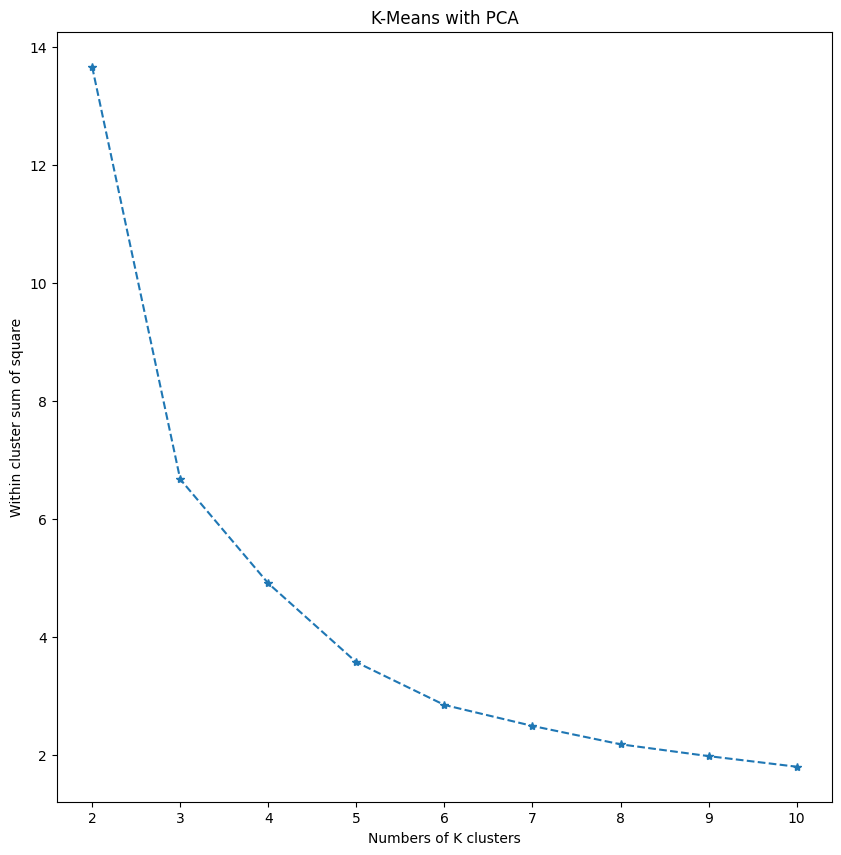

(3254, 2)
[('india', 278), ('international', 149), ('science', 46), ('news', 45), ('entertainment', 31), ('sport', 4)]
[('sport', 75), ('india', 2), ('international', 1)]
[('india', 365), ('international', 219), ('news', 71), ('science', 29), ('sport', 3), ('entertainment', 1)]
[('india', 144), ('entertainment', 82), ('international', 80), ('science', 23), ('news', 11), ('sport', 4)]
[('sport', 49), ('india', 1)]
[('sport', 38), ('entertainment', 22), ('international', 15), ('india', 11), ('news', 3)]


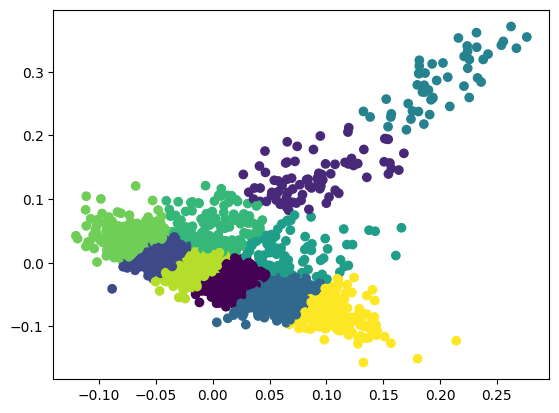

In [ ]:
### plotting withing clusters samples distance

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### plotting withing clusters samples distance
plt.figure(figsize = (10,10))
plt.plot(range(2,11),wcss,marker = '*', linestyle = '--')
plt.xlabel('Numbers of K clusters')
plt.ylabel('Within cluster sum of square')
plt.title('K-Means with PCA')
plt.show()


#plotting clusters
labels = clustering.labels_.tolist()
# print(labels)

plt.figure()


colors = ["#FFFF00", "#008000", "#0000FF", "#800080", '#800000', '#FFA500']
# df['c'] = cluster_labels.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4], 5:colors[5]})
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = cluster_labels)

print(reduced_data.shape)

df['clusters'] = cluster_labels

cluster_groups = df[['Final','clean', 'clusters']].sort_values(by=['clusters'], ascending=False).groupby('clusters').head(10000)

from collections import Counter
for cluster_num in range(6):
    news = cluster_groups[cluster_groups['clusters'] == cluster_num]['Final'].values.tolist()
    lst = []
    for i in news:
      lst.append(i.split("|")[0])
    print(Counter(lst).most_common(10))






In [ ]:
df['clusters']

412     5
1895    1
970     5
1714    5
1339    5
       ..
2254    1
2196    2
329     4
1527    2
1424    2
Name: clusters, Length: 3254, dtype: int32

In [ ]:
for cluster_num in range(6):
    news = cluster_groups[cluster_groups['clusters'] == cluster_num]['clean'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print(" ".join(news[0]))
    print('-'*80)
    print(news[1])
    print('-'*80)
    print(news[2])
    print('-'*80)
    print(news[3])
    print('-'*80)
    print(news[4])
    print('-'*80)
    print(news[5])
    print('-'*80)
    print(news[6])
    print('-'*80)

CLUSTER #1
entertainment|कई निर्देशकों व्यस्तता वजह मना वाली दीपिका फेसबुक नंबर वन मिलियन यानी डेढ़ करोड़ फ़ॉलोअर वाली दीपिका पादुकोण फेसबुक रेस अमिताभ बच्चन पीछे छोड़ दीपिका के 'जश्न बॉलीवुड दीवाना सलमान शाहरुख़ आमिर सूची काफी अभिनेत्री नाम दीपिका के आसपास नहीं बीबीसी दिए इंटरव्यू दीपिका मानती वो प्रशंसकों वजह करियर के उतार-चढ़ाव वो हमेशा कॉमेडियन सुनील ग्रोवर के शो मैड इंडिया संकट के बादल छा शो के होस्ट मनीष पॉल शो मार्च के अलविदा कहने फैसला हँसी के शो हँसने भाड़े के मनीष पॉल शो के लेखकों स्क्रिप्ट टीआरपी आने के चक्कर टीवी चैनल दख़लअंदाज़ी काफ़ी परेशान निरंतर बदलाव आने शो स्थिर नहीं पाया ग़ौरतलब स्टार प्लस गुत्थी के शो जल्द ऑफ़ एयर करके म्यूज़िकल शो लाने बात रजनीकांतकुछ चुनाव तारीख नहीं बदल रजनीकांत फ़िल्म कोचेडियान चुनावी माहौल रिलीज़ वाली बड़ी फ़िल्मों क़यास लगाए फ़िल्म रिलीज़ तारीख अप्रैल चुनाव के मद्देनज़र शायद बढ़ाया रजनी के डायलॉग सिखाएँगे मैनेजमेंट के गुर अप्रैल तमिलनाडु चुनाव दिन रजनीकांत चाहते फ़िल्म के प्रचार चुनाव अड़चन न आए जिसके चलते फ़ैसला
------------------------------

In [ ]:
# # Create a DataFrame with articles and their tags
tags_df = pd.DataFrame({
    # 'article': data['Final'],
    'article': data['Final'].apply(lambda x: x.split('|', 1)[-1].strip()),
    'tag': data['Final'].apply(lambda x: x.split('|')[0].strip())  # Extract the label from the article
})
# print(tags_df.head())

# Print the number of unique tags
num_unique_tags = tags_df['tag'].nunique()
print(f"Number of unique tags: {num_unique_tags}")

# Print the names of unique tags
unique_tags = tags_df['tag'].unique()
print("Unique tag names:")
for tag in unique_tags:
    print(tag,list(tags_df['tag']).count(tag))


Number of unique tags: 6
Unique tag names:
entertainment 285
india 1385
international 904
news 230
science 192
sport 258


In [ ]:
print(len(cluster_labels))
print(cluster_labels)
# for i in range(600):
#   if(i>=579 and i<=581):
#     print(cluster_labels[i])

3254
[9 8 9 ... 5 4 4]
